# Faltas Administrativas

## imports

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from warnings import simplefilter
simplefilter(action="ignore", category=FutureWarning)
%matplotlib inline

## Leer archivo

In [59]:
temp = pd.read_csv("data/hmofaltasadministrativas.csv", encoding="latin1")
temp.drop(["zona","peso","estatura","nacimiento","nacimiento","estatura","sexo"], axis=1, inplace=True)
df = temp.copy()
df.head(2)

,fecha_presentacion,colonia_delito,motivo_remision,colonia_detenido
0,01/01/2015 00:39,ALVARO OBREGON (N),CAUSAR O PROVOCAR ESCANDALO EN LUGARES PUBLICO...,SAHUARO AMPLIACION
1,01/01/2015 00:39,PALO VERDE INDEUR,CAUSAR O PROVOCAR ESCANDALO EN LUGARES PUBLICO...,PALO VERDE INDEUR


 ## Dataset base

In [60]:
temp = df["colonia_delito"] == df["colonia_detenido"]
one_or_zero = lambda x: 1 if x == True else 0
df["infractor_local"] = list(map(one_or_zero, temp))
df["dia_semana"] = pd.to_datetime(df["fecha_presentacion"]).apply(lambda x: x.weekday())
df.drop(["fecha_presentacion"], axis=1, inplace=True)
df.head(2)

,colonia_delito,motivo_remision,colonia_detenido,infractor_local,dia_semana
0,ALVARO OBREGON (N),CAUSAR O PROVOCAR ESCANDALO EN LUGARES PUBLICO...,SAHUARO AMPLIACION,0,3
1,PALO VERDE INDEUR,CAUSAR O PROVOCAR ESCANDALO EN LUGARES PUBLICO...,PALO VERDE INDEUR,1,3


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122192 entries, 0 to 122191
Data columns (total 5 columns):
colonia_delito      122192 non-null object
motivo_remision     122192 non-null object
colonia_detenido    122192 non-null object
infractor_local     122192 non-null int64
dia_semana          122192 non-null int64
dtypes: int64(2), object(3)
memory usage: 4.7+ MB


## Grafica de barra locales Vs no locales (totales)

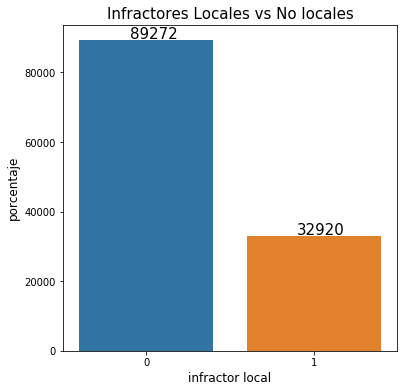

In [62]:
plt.figure(figsize=(6,6))
temp = df["infractor_local"].value_counts()
x = list(temp.index)
y = temp.values

total = np.sum(temp.values)
step = (total * 0.5)/100

p = sns.barplot(x="infractor_local", y="total", data=pd.DataFrame({"infractor_local": x , "total": y}));
p.set_title("Infractores Locales vs No locales",fontsize=15)
p.set_xlabel("infractor local", fontsize=12)
p.set_ylabel("porcentaje", fontsize=12)

for i in zip(x,y):
    p.text(i[0]-.1,i[1]+step,i[1],fontsize=15, color="black")

## Grafica de barra locales Vs no locales (porcetajes)

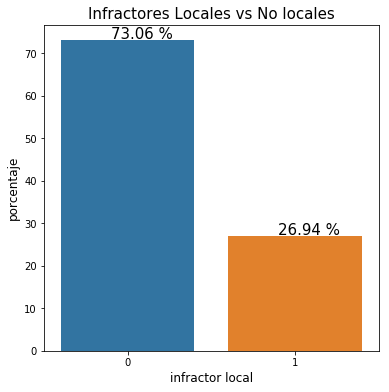

In [63]:
plt.figure(figsize=(6,6))
temp = df["infractor_local"].value_counts()
x = list(temp.index)
total = np.sum(temp.values)
y = np.around((temp.values * 100)/total,2)

step = (100 * 0.5)/100

p = sns.barplot(x="infractor_local", y="porcentaje", data=pd.DataFrame({"infractor_local": x , "porcentaje": y}));
p.set_title("Infractores Locales vs No locales",fontsize=15)
p.set_xlabel("infractor local", fontsize=12)
p.set_ylabel("porcentaje", fontsize=12)

for i in zip(x,y):
    p.text(i[0]-0.1,i[1]+step,str(i[1])+" %",fontsize=15, color="black")
    

## Crear datos dummy

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122192 entries, 0 to 122191
Data columns (total 5 columns):
colonia_delito      122192 non-null object
motivo_remision     122192 non-null object
colonia_detenido    122192 non-null object
infractor_local     122192 non-null int64
dia_semana          122192 non-null int64
dtypes: int64(2), object(3)
memory usage: 4.7+ MB


In [65]:
temp = df.copy()
dummy_colonia_delito = pd.get_dummies(temp["colonia_delito"])
dummy_motivo_remision = pd.get_dummies(temp["motivo_remision"])
dummy_colonia_detenido = pd.get_dummies(temp["colonia_detenido"])

temp.drop(["colonia_delito","motivo_remision","colonia_detenido"], axis=1, inplace=True)

In [67]:
df = pd.concat([temp, dummy_colonia_delito, dummy_motivo_remision,dummy_colonia_detenido], axis = 1)

## Aplicar modelo

In [76]:
all_columns = df.columns.to_list()
columns = list(filter(lambda x: x!='infractor_local',all_columns)) 

X = df[columns]
y = df['infractor_local']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=9)

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [87]:
model.score(X_test, y_test)

0.7728221285649985

In [82]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.81      0.90      0.85     17936
           1       0.61      0.41      0.49      6503

    accuracy                           0.77     24439
   macro avg       0.71      0.66      0.67     24439
weighted avg       0.76      0.77      0.76     24439



## Cross validation

In [85]:
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(X_train,y_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'penalty': 'l1', 'C': 0.1}
accuracy : 0.7720683764181151
